In [25]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time
import pyvista as pv
from EDITED_aux_functions_time import *
from WarpPINN import WarpPINN
from skimage import measure
import meshio
import vtk
import time
from tqdm import tqdm
import cv2
import tetgen
from skimage.measure import label, regionprops
import pandas as pd
from scipy.ndimage import map_coordinates

In [26]:
patients = os.listdir('ACDC_raw/database/training')
patients.remove('.ipynb_checkpoints')
patients.sort()

In [27]:
patient_info = pd.read_csv('ACDC_training_patient_info.csv')

In [28]:
patient_info = patient_info.set_index('patient', drop=True)

In [29]:
metrics_file = 'metrics.csv'

In [30]:
patient_info.head(5)

,ED_frame,ES_frame,Group,Height,Weight,NbFrame
patient,,,,,,
patient001,1,12,DCM,184.0,95.0,30
patient002,1,12,DCM,160.0,70.0,30
patient003,1,15,DCM,165.0,77.0,30
patient004,1,15,DCM,159.0,46.0,28
patient005,1,13,DCM,165.0,77.0,30


In [31]:
if os.path.exists( metrics_file ):
    metrics = pd.read_csv( metrics_file )
    metrics = metrics.set_index('patient', drop = True)
    metrics.index.name = 'patient'
else:
    metrics = pd.DataFrame(index = patients , columns = ['MSE', 'SSIM', 'MCD', 'HD', 'Dice', '||J| - 1|', 'Group'])
    metrics.index.name = 'patient'

In [32]:
metrics.head()

,MSE,SSIM,MCD,HD,Dice,||J| - 1|
patient,,,,,,
patient001,0.131098,0.921385,1.241269,8.823303,0.615805,0.000861
patient002,0.120004,0.935161,1.184746,9.030560,0.644052,0.001283
patient003,0.108612,0.986112,3.373668,15.503990,0.747804,0.000262
patient004,0.158877,0.949741,3.045992,14.273862,0.687080,0.001604
patient005,0.147672,0.850521,0.792461,6.430984,0.568904,0.006274


In [33]:
def distance_metric_myo(seg_A, seg_B, dx):
# Measure the distance errors between the contours of two segmentations
# The manual contours are drawn on 2D slices.
# We calculate contour to contour distance for each slice.

    table_md = []
    table_hd = []
    Z, Y, X = seg_A.shape
    for z in range(Z):
        slice_A = seg_A[z, :, :].astype(np.uint8)
        slice_B = seg_B[z, :, :].astype(np.uint8)
        
        # The distance is defined only when both contours exist on this slice
        if np.sum(slice_A) > 0 and np.sum(slice_B) > 0:
            # Find contours and retrieve all the points
            contours, _ = cv2.findContours(cv2.inRange(slice_A, 1, 1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            pts_A = contours[0]
            for i in range(1, len(contours)):
                pts_A = np.vstack((pts_A, contours[i]))

            contours, _ = cv2.findContours(cv2.inRange(slice_B, 1, 1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            pts_B = contours[0]
            for i in range(1, len(contours)):
                pts_B = np.vstack((pts_B, contours[i]))

    # Distance matrix between point sets
    M = np.zeros((len(pts_A), len(pts_B)))
    for i in range(len(pts_A)):
        for j in range(len(pts_B)):
            M[i, j] = np.linalg.norm(pts_A[i, 0] - pts_B[j, 0])
            # Mean distance and hausdorff distance
            md = 0.5 * (np.mean(np.min(M, axis=0)) + np.mean(np.min(M, axis=1))) * dx
            hd = np.max([np.max(np.min(M, axis=0)), np.max(np.min(M, axis=1))]) * dx
            table_md += [md]
            table_hd += [hd]

    # Return the mean distance and Hausdorff distance across 2D slices
    mean_md = np.mean(table_md) if table_md else None
    mean_hd = np.mean(table_hd) if table_hd else None
    return mean_md, mean_hd

This is patient: 001
The ES frame is: 12
ES Frame No: 12
ES Frame Path: ACDC_raw/database/training/patient001/patient001_frame12_gt.nii.gz
Constructing Neural Network...
Device mapping: no known devices.
task:0/device:CPU:0
gradients_11/gradients_2/Add_8_grad/Sum_grad/range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_2/Add_8_grad/Sum_grad/range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_2/Add_8_grad/Sum_grad/ones/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_3/Add_8_grad/Sum_grad/Size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_3/Add_8_grad/Sum_grad/range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_3/Add_8_grad/Sum_grad/range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_11/gradients_3/Add_8_grad/Sum_grad/ones/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
g

NameError: name 'es_u1_pred' is not defined

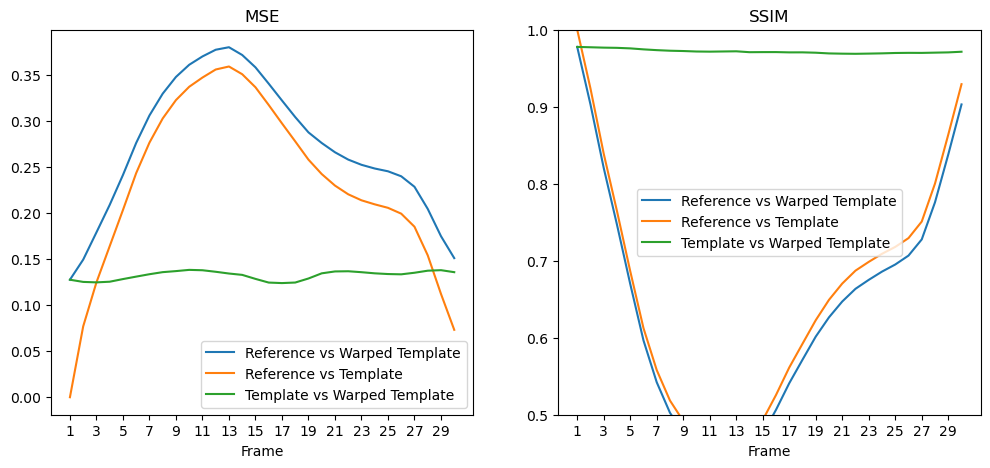

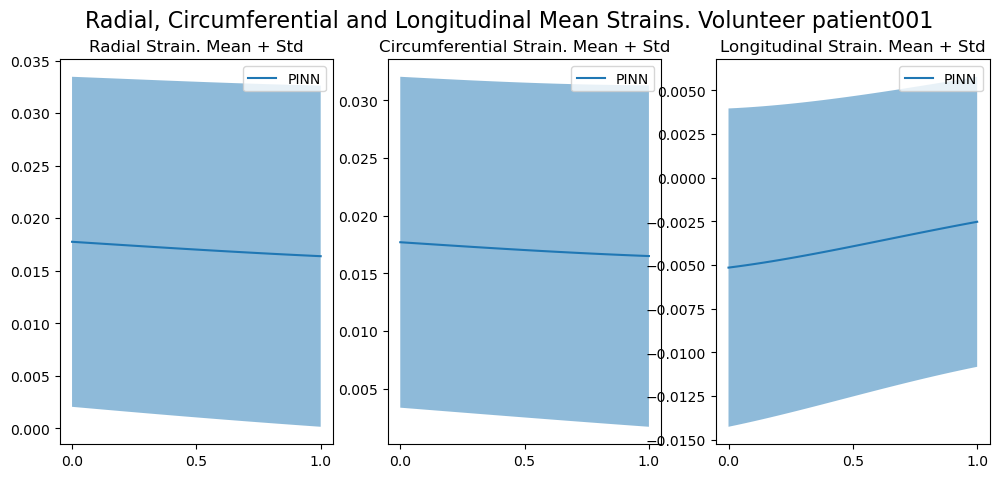

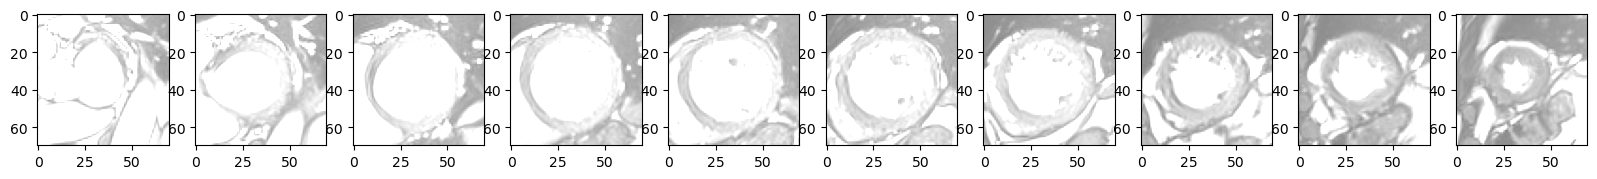

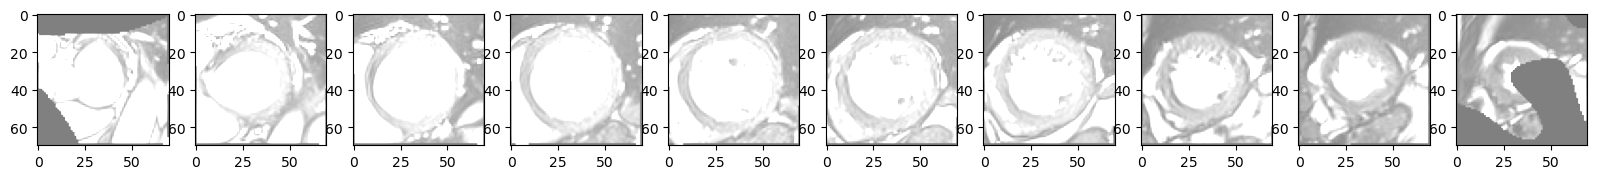

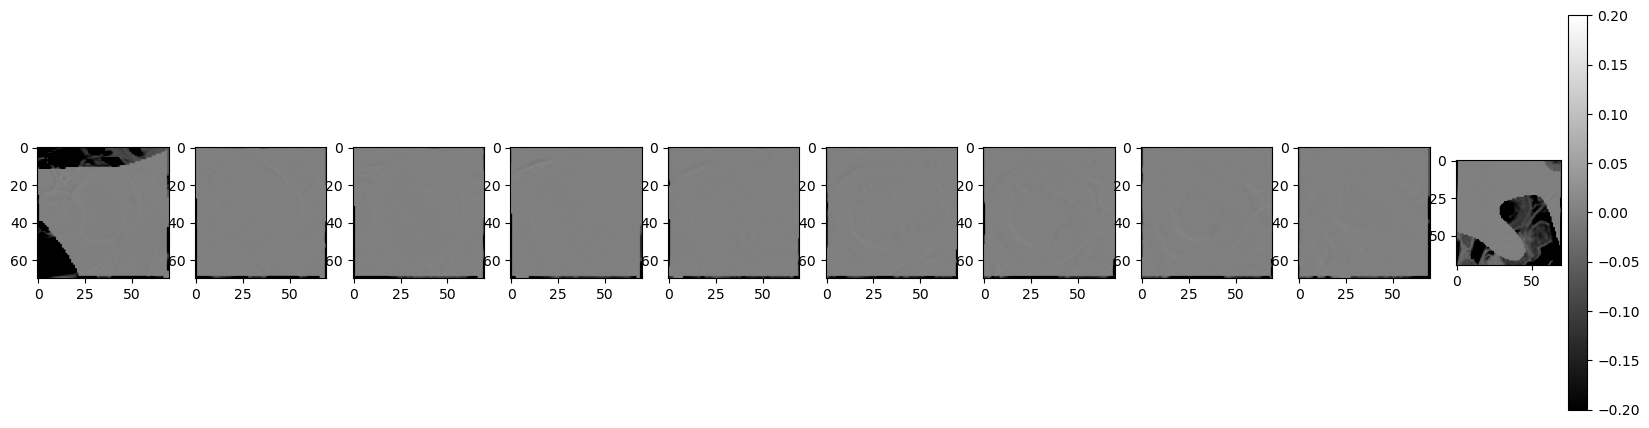

In [35]:
for idx_pt in range(1): #len(patients)):
    patient = patients[idx_pt]
    es_frame_no = patient_info['ES_frame'][patient]
    data_path = os.path.join( 'ACDC_raw/database/training', patient)

    imt_path = glob.glob(f'{data_path}/*4d.nii.gz')[0]
    imt_data = nib.load(imt_path)
    imt = imt_data.get_fdata()
    header = imt_data.header

    patient_no = patient[7:]
    print(f'This is patient: {patient_no}')
    print(f'The ES frame is: {es_frame_no}')

    # Pixel spacing of image
    pix_dim = header['pixdim']
    pixsp_x = pix_dim[1]
    pixsp_y = pix_dim[2]
    pixsp_z = pix_dim[3]

    imt = np.transpose(imt, [3, 2, 1, 0])

    frames = imt.shape[0]
    slices = imt.shape[1]
    
    #Importing Ground-Truth Segmentation/End-Diastolic 
    
    segm_imt_path = glob.glob(f'{data_path}/*frame01_gt.nii*')[0]
    segm_imt_data = nib.load(segm_imt_path)
    segm_imt = segm_imt_data.get_fdata()
    segm_header = segm_imt_data.header
    dim = segm_header['dim']
    dims = segm_imt.shape
    mask_pixdim = segm_header['pixdim']
    
    # Create a binary mask of GT
    
    low = 1.5 #
    high = 3
    mask = np.zeros(dims)
    mask[(segm_imt > low) & (segm_imt < high)] = 1
    
    #Importing End-Systolic Segmentation 
    
    es_frame_no = int(patient_info['ES_frame'][patient])
    print(f'ES Frame No: {es_frame_no}')
    es_imt_path = glob.glob(f'{data_path}/*frame*{es_frame_no}*_gt.nii*')[0]
    print('ES Frame Path: '+ es_imt_path)
    es_imt_data = nib.load(es_imt_path)
    es_imt = es_imt_data.get_fdata()
    es_imt = np.transpose(es_imt, [2, 1, 0])

    
    # Create a binary mask of ES frame
    
    low = 1.5 
    high = 3
    es_mask = np.zeros(es_imt.shape)
    es_mask[(es_imt > low) & (es_imt < high)] = 1

    #Crop mask 
    
    s=0
    img = mask[:, :, s]
    labeled_img = label(img)
    regions = regionprops(labeled_img)
    
    if len(regions) == 0:
       s=1 
       img = mask[:, :, s]
       labeled_img = label(img)
       regions = regionprops(labeled_img)
    
    myocardium_region = max(regions, key=lambda x: x.area)

    # bounding box of myo
    min_x, min_y, max_x, max_y = myocardium_region.bbox

    # expand bounding box 5 pix in each direction if possible
    buffer = 5 
    min_x = max(0, min_x - buffer)
    min_y = max(0, min_y - buffer)
    max_x = min(img.shape[0], max_x + buffer)
    max_y = min(img.shape[1], max_y + buffer)


    for i in range(s+1,dims[2]): 
        img = mask[:, :, i]
        labeled_img = label(img)
        regions = regionprops(labeled_img)
        
        if len(regions) == 0:
           continue
        
        myocardium_region = max(regions, key=lambda x: x.area)

        # bounding box of myo
        minr, minc, maxr, maxc = myocardium_region.bbox


        # expand bounding box 20 pix in each direction if possible
        minr = max(0, minr - buffer)
        minc = max(0, minc - buffer)
        maxr = min(img.shape[0], maxr + buffer)
        maxc = min(img.shape[1], maxc + buffer)

        if minr < min_x:
            min_x = minr
        if maxr > max_x:
            max_x = maxr
        if minc < min_y:
            min_y = minc
        if maxc > max_y:
            max_y = maxc

    def round_to_even(number):
        rounded_number = round(number)
        if rounded_number % 2 != 0:  # Check if the number is odd
            rounded_number += 1     # Increment by 1 to make it even
        return rounded_number

    crop_x_in = round_to_even(min_x)
    crop_x_end = round_to_even(max_x)
    crop_y_in = round_to_even(min_y)
    crop_y_end = round_to_even(max_y)

    crop_str = str(crop_x_in)+'_'+str(crop_x_end)+'_'+str(crop_y_in)+'_'+str(crop_y_end)


    imt = imt[:, :, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

    # Reference image is the first time in the stack

    imr = imt[0, :, :, :]


    pad_mask = np.pad(mask, ((0, 0), (0, 0), (1, 1)), mode='constant')

    Nx = dim[1]
    Ny = dim[2]
    Nz = dim[3]

    xp = np.arange(Nx)
    yp = np.arange(Ny)
    zp = np.arange(Nz)

    Y, Z, X = np.meshgrid(yp, zp, xp)

    X = X[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]
    Y = Y[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]
    Z = Z[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]

    X = X.ravel()[:,None]
    Y = Y.ravel()[:,None]
    Z = Z.ravel()[:,None]

    # Pixel coordinates in a list
    im_pix = np.hstack((X, Y, Z))
    im_mesh = pixel_to_mesh(im_pix, pixsp_x, pixsp_y, pixsp_z)

    #Surface Mesh Generation

    # Define scaling factors for each axis
    scale_x = mask_pixdim[1] # Example scaling factor for the x-axis
    scale_y = mask_pixdim[2] # Example scaling factor for the y-axis
    scale_z = mask_pixdim[3] # Example scaling factor for the z-axis

    vertices, triangles, norm, val = measure.marching_cubes(volume=pad_mask,
                                                     level=1e-12,
                                                     spacing=(scale_x, scale_y, scale_z),
                                                     gradient_direction='descent',
                                                     step_size=1,
                                                     allow_degenerate=False,
                                                     method='lewiner')


    # Create a pyvista mesh object using the vertices and triangles
    mesh = pv.PolyData(vertices)
    faces = np.hstack((np.full((len(triangles), 1), 3), triangles)).ravel()
    # Create the cell type array (VTK_TRIANGLE = 5)
    cell_types = np.full(len(triangles), 5)
    # create the unstructured grid directly from the numpy arrays
    surface = pv.UnstructuredGrid(faces, cell_types, vertices)
    
    #Generating Volume Mesh
    try:
        faces = surface.cell_connectivity.reshape(-1,3)
        tet = tetgen.TetGen(surface.points, faces)
        tet.make_manifold()
        tet.tetrahedralize(mindihedral=25, minratio = 1.1)
        volume = tet.grid
    except RuntimeError:
        print(f'Cannot make volume mesh for patient {patient_no}! Moving to next patient.')
        continue

    #Smoothing Surface Mesh

    mesh = surface.extract_surface()
    mesh = mesh.triangulate().clean(tolerance=1e-8)
    mesh = mesh.subdivide_adaptive(max_n_passes=100, max_edge_len=1.0)
    # Volume preserving smoothing
    mesh.smooth_taubin(n_iter=100, pass_band=0.75, edge_angle=30, feature_angle=45,
                       boundary_smoothing=True, feature_smoothing=True,
                       non_manifold_smoothing=True, normalize_coordinates=False,
                       inplace=True)
    # Small Laplacian smoothing to remove outliers
    mesh.smooth(n_iter=10, edge_angle=150, feature_angle=180, feature_smoothing=True,
                relaxation_factor=0.1, convergence=0.1, inplace=True)

    surface = mesh.clean(tolerance=1e-8)
    surface = surface.cast_to_unstructured_grid()
    
    #Save surface and volume meshes

    volume.save(f'ACDC_raw/database/training/patient{patient_no}/patient{patient_no}_vol.vtk')
    surface.save(f'ACDC_raw/database/training/patient{patient_no}/patient{patient_no}_surf_vol.vtk')
    

    # Mesh coords of image voxels and segmentation nodes
    im_mesh, segm_mesh = im_and_segm_mesh(imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, data_path)

    # Mesh coords for background nodes
    bg_mesh_file = os.path.join(data_path, 'background_points_'+crop_str+'.npy')
    bg_mesh = background_mesh(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bg_mesh_file, slices)

    # Boolean mask: 1 if the voxel is in the LV, 0 otherwise
    bool_mask_file = os.path.join(data_path, 'boolean_mask_'+crop_str+'.npy')
    bool_mask = boolean_mask(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bool_mask_file )

    ### Neural Network ###

    # Layers for u1, u2 and u3
    neu = 2**6
    layers_u = [4, neu, neu, neu, neu, neu, 3]

    reg_mask = 1
    lmbmu = 10**5
    mu_NeoHook = 1e-5

    # Number of iterations desired for the registration from t_1 to t_i
    It = 10000             #I CHANGED the iterations for 300000 to 10000
    batch_size = 1000
    # Number of points in LV used to calculate the Neo Hookean by minibatch
    N_nodes = len(segm_mesh)
    # Number of epochs 
    nEpoch = int( np.ceil(It * batch_size / N_nodes) )

    pix_crop = [pixsp_x, pixsp_y, pixsp_z, crop_x_in, crop_y_in]

    model = WarpPINN(imr, imt, layers_u, bool_mask, im_mesh, segm_mesh, bg_mesh, lmbmu, pix_crop, reg_mask)

    print('# of epics: ' + str(nEpoch))
    
    t0 = time.time()
    tol_pretrain = 1e-6
    model.pretrain(tol_pretrain)
    t1 = time.time()
    
        # An exception may occur during backpropagation if J = 0 at some point.

    try:
        # Choose either L1 norm or L2 norm to measure the difference between reference and warped template images

        model.train_Adam_L1_NeoHook(nEpoch, mu_NeoHook, size=batch_size)
        #model.train_Adam_MSE_NeoHook(nEpoch, mu_NeoHook, size=batch_size) 

    except:

        print('J = 0 at some point. Training has stopped. Predictions are made from last iteration.')

    finally:

        ### Save model ###

        str_neu = str(neu)
        str_mask = str(reg_mask)
        str_batch = str(batch_size)

        str_mu_NeoHook = str(mu_NeoHook)
        str_lmbmu = str(lmbmu)

        model_name = 'model_L1_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch
        # model_name = 'model_L2_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch

        model_dir = os.path.join( 'results', 'L1', patient, model_name) 
        #model_dir = os.path.join( 'results', 'L2', volunteer, model_name) 

        model_save = os.path.join(model_dir, model_name)

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model.saver.save(model.sess, model_save)

        t2 = time.time()    

        ### Loading data for post-processing ###

        # Mesh coords of nodes in the ventricle to be deformed to simulate heart beating
        surf_mesh = meshio.read( os.path.join( data_path, patient +'_surf_vol.vtk' ))


        # Ground truth landmarks. Get landmarks at first frame from observer 1 (in the first frame they are the same for observer 2)
        #gt_inria_lmks_path = os.path.join(data_path, 'LMKS_GT/INRIA_COORDINATES')
        #gt_obs1 = os.path.join(gt_inria_lmks_path, 'obs1_groundTruth00.vtk')
        #lmks_gt_obs1 = read_lmks_mesh(gt_obs1)

        # For strains

        # Mesh coords
        origin = np.mean(surf_mesh.points, axis = 0)
        cart_coords = surf_mesh.points - origin
        angle = np.arctan2(cart_coords[:,1], cart_coords[:,0])

        rho = np.hstack((np.cos(angle)[:,None], np.sin(angle)[:,None]))
        theta = np.hstack((-np.sin(angle)[:,None], np.cos(angle)[:,None]))

        rho_1 = np.reshape(rho, [-1,1,2])
        rho_2 = np.reshape(rho, [-1,2,1])

        theta_1 = np.reshape(theta, [-1,1,2])
        theta_2 = np.reshape(theta, [-1,2,1])

        # Surface at first frame
        surf_path = os.path.join(model_dir, 'surfaces')
        if not os.path.exists(surf_path):
            os.makedirs( surf_path )

        num_nodes = len(surf_mesh.points)

        file_name = os.path.join(surf_path, 'p001_surf.vtk')
        meshio.write(file_name, meshio.Mesh(points=surf_mesh.points, cells = {'triangle': surf_mesh.cells_dict['triangle']}, \
                        point_data = {'radStrain':np.zeros([num_nodes]), 'circStrain':np.zeros([num_nodes]), 'longStrain': np.zeros([num_nodes]), 'Jacobian': np.ones([num_nodes])}))

        # Landmarks at first frame
        lmks_path = os.path.join(model_dir, 'lmks')
        if not os.path.exists( lmks_path ):
            os.makedirs( lmks_path )

        #file_name = os.path.join( lmks_path, 'lmks_results{0}.vtk'.format(0))
        #meshio.write(file_name, meshio.Mesh(points=lmks_gt_obs1, cells={}))

        # To generate some basic plots for Reference image vs Predicted image
        mse_pred_list = []
        ssim_pred_list = []
        #dice_pred_list = []

        # To generate some basic plots for Reference image vs Template image
        mse_temp_list = []
        ssim_temp_list = []
        #dice_temp_list = []

         # To generate some basic plots for Template image vs Warped image
        mse_wartemp_list = []
        ssim_wartemp_list = []
        #dice_wartemp_list = []

        # To generate some basic plots for strains
        # Radial
        mean_rr = np.zeros([frames])
        median_rr = np.zeros([frames])
        std_rr = np.zeros([frames])
        # Circumferential
        mean_cc = np.zeros([frames])
        median_cc = np.zeros([frames])
        std_cc = np.zeros([frames])
        # Longitudinal
        mean_ll = np.zeros([frames])
        median_ll = np.zeros([frames])
        std_ll = np.zeros([frames])

        imt_resc2 = np.zeros(np.shape(imt))
        imt_pred2 = np.zeros(np.shape(imt))


        # Warping at different times

        for i in range(frames):

            # Surface warp
            surf_mesh_warp, u1, u2, u3, u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z, J = model.surface_deformation(surface.points, i)

            grad_um = np.hstack((u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z))
            grad_um = np.reshape(grad_um, [-1, 3, 3])
            grad_um_t = np.transpose(grad_um, [0, 2, 1])

            Em = 1/2 * (grad_um + grad_um_t + np.matmul(grad_um_t, grad_um))

            Em_new = Em[:,0:2,0:2]
            # Radial strain
            Em_rr = np.matmul(rho_1, np.matmul(Em_new, rho_2))
            # Circumferential strain
            Em_cc = np.matmul(theta_1, np.matmul(Em_new, theta_2))
            # Longitudinal strain
            Em_ll = Em[:,2,2]

            mean_rr[i] = np.mean(Em_rr)
            median_rr[i] = np.median(Em_rr)
            std_rr[i] = np.std(Em_rr)

            mean_cc[i] = np.mean(Em_cc)
            median_cc[i] = np.median(Em_cc)
            std_cc[i] = np.std(Em_cc)

            mean_ll[i] = np.mean(Em_ll)
            median_ll[i] = np.median(Em_ll)
            std_ll[i] = np.std(Em_ll)

            # Save warped surface with strains and jacobian
            file_name = os.path.join(surf_path, 'p{0}_surf.vtk'.format(i+1))
            meshio.write(file_name, meshio.Mesh(points=surf_mesh_warp, cells = {'triangle': surf_mesh.cells_dict['triangle']}, \
                        point_data = {'radStrain':Em_rr, 'circStrain':Em_cc, 'longStrain':Em_ll, 'Jacobian': J}))


            # Save warped Landmarks 
            #lmks_warp_obs1_mesh = model.lmks_deformation(lmks_gt_obs1, i)
            #file_name = os.path.join(lmks_path, 'lmks_results{0}.vtk'.format(i+1))
            #meshio.write(file_name, meshio.Mesh(points=lmks_warp_obs1_mesh, cells={}))

            # Prediction on voxel coordinates

            imr_pred, u1_pred, u2_pred, u3_pred, u1x_pred, u1y_pred, u1z_pred, u2x_pred, u2y_pred, u2z_pred, u3x_pred, u3y_pred, u3z_pred, J_pred = model.predict(i)
            
            #if frames[i] == es_frame_no:
             #   print(f'Taking the deformation field from frame no: {frame[i]}')
              #  es_u1_pred = u1_pred
               # es_u2_pred = u2_pred
                #es_u3_pred = u3_pred

            imt_i = imt[i,:,:,:]
            ub_im = np.max([np.max(imr), np.max(imt)])
            lb_im = np.min([np.min(imr), np.min(imt)])
            imr_resc = (imr - lb_im) / (ub_im - lb_im)
            imt_resc = (imt_i - lb_im) / (ub_im - lb_im)

            # Comparing predicted image and reference image
            print('Reference image vs predicted image frame {0}'.format(i))
            compare_images(imr_resc[1:-1], imr_pred[1:-1])
            print('Reference image vs Template image frame {0}'.format(i))
            compare_images(imr_resc[1:-1], imt_resc[1:-1])

            mse_pred_list.append( np.sqrt((np.square(imr_resc[1:-1]-imr_pred[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
            mse_temp_list.append( np.sqrt((np.square(imr_resc[1:-1]-imt_resc[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
            mse_wartemp_list.append( np.sqrt((np.square(imt_resc[1:-1]-imr_pred[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )

            ssim_pred_list.append( ssim(imr_resc[1:-1], imr_pred[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min(), multichannel=True, win_size=3)) #added data range to ssim method
            ssim_temp_list.append( ssim(imr_resc[1:-1], imt_resc[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min(), multichannel=True, win_size=3)) #added data range to ssim method
            ssim_wartemp_list.append( ssim(imt_resc[1:-1], imr_pred[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min(), multichannel=True, win_size=3)) 

            imt_resc2[i,:,:,:] = imt_resc
            imt_pred2[i,:,:,:] = imr_pred

        np.save( os.path.join(model_dir, 'mse_pred_list.npy'), np.array(mse_pred_list))
        np.save( os.path.join(model_dir, 'ssim_pred_list.npy'), np.array(ssim_pred_list))
        np.save( os.path.join(model_dir, 'mse_temp_list.npy'), np.array(mse_temp_list))
        np.save( os.path.join(model_dir, 'ssim_temp_list.npy'), np.array(ssim_temp_list))

        np.save( os.path.join(model_dir, 'loss_registration.npy'), np.array(model.lossit_MSE))
        np.save( os.path.join(model_dir, 'loss_nh.npy'), np.array(model.lossit_NeoHook))
        np.save( os.path.join(model_dir, 'loss.npy'), np.array(model.lossit_value))

        # Generate plots of MSE and SSIM
        mse_ssim(model_dir, frames, mse_pred_list, mse_temp_list, mse_wartemp_list, ssim_pred_list, ssim_temp_list, ssim_wartemp_list)

        # Generate strain graphs
        pinn_strains = np.vstack([mean_rr, median_rr, std_rr, mean_cc, median_cc, std_cc, mean_ll, median_ll, std_ll ])
        global_strain(data_path, model_dir, frames, pinn_strains)

        #box_plots(data_path, model_dir)
  
    
    #Save template images

    fig,ax = plt.subplots(1, slices, figsize=(20,20))
    for i in range(slices):
        ax[i].imshow(imt_resc2[10, i, :, :], cmap='gray', vmin=-0.2, vmax=0.2)
    # Save the figure
    fig.savefig(f'results/L1/patient{patient_no}/model_L1_1e-05_NH_lmbmu_100000_mask_1_neu_64_batch_1000/Figures/patient{patient_no}_template_image_frame_10.png')

    #Save prediction images
    fig,ax = plt.subplots(1, slices, figsize=(20,20))
    for i in range(slices):
        ax[i].imshow(imt_pred2[10, i, :, :], cmap='gray', vmin=-0.2, vmax=0.2)
    # Save the figure
    fig.savefig(f'results/L1/patient{patient_no}/model_L1_1e-05_NH_lmbmu_100000_mask_1_neu_64_batch_1000/Figures/patient{patient_no}_prediction_image_frame_10.png')

    
    #Save difference between prediction and template images
    fig,ax = plt.subplots(1, slices, figsize=(20,20))
    for i in range(slices):
        im = ax[i].imshow(imt_pred2[10,i, :, :] - imt_resc2[10,i, :, :], cmap='gray', vmin=-0.2, vmax=0.2)
    fig.colorbar(im, ax=ax[i])
    # Save the figure
    fig.savefig(f'results/L1/patient{patient_no}/model_L1_1e-05_NH_lmbmu_100000_mask_1_neu_64_batch_1000/Figures/patient{patient_no}_difference_image_frame_10.png')
    
    #Calculate Dice Score
    
    crop_mask = mask.transpose(2, 1, 0)
    crop_mask = crop_mask[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)
    es_mask = es_mask[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

    z_size, y_size, x_size = crop_mask.shape
    
    u1_pred_rs = es_u1_pred.reshape(crop_mask.shape)
    u2_pred_rs = es_u2_pred.reshape(crop_mask.shape)
    u3_pred_rs = es_u3_pred.reshape(crop_mask.shape)
    
    coords = np.indices((z_size, y_size, x_size))
    
    warped_x_coords = coords[2] - u1_pred_rs
    warped_y_coords = coords[1] - u2_pred_rs
    warped_z_coords = coords[0] - u3_pred_rs
    
    warped_mask = map_coordinates(es_mask, [warped_z_coords, warped_y_coords, warped_x_coords], order=1, mode='nearest')
    warped_mask[warped_mask != 0] = 1

    crop_mask_bool = crop_mask > 0
    warped_mask_bool = warped_mask > 0

    overlap = np.logical_and(crop_mask_bool, warped_mask_bool)
    overlap_count = np.sum(overlap)
    
    dice = 2 * overlap_count / (np.sum(crop_mask_bool) + np.sum(warped_mask_bool))
    
    md, hd = distance_metric_myo(crop_mask_bool, warped_mask_bool, mask_pixdim[1])
    
    print(f'Dice score is: {dice}')
    
    metrics['||J| - 1|'][patients[idx_pt]] = abs(abs(J.mean()) - 1)
    metrics['Dice'][patients[idx_pt]] = dice
    metrics['MCD'][patients[idx_pt]] = md
    metrics['HD'][patients[idx_pt]] = hd
    metrics['MSE'][patients[idx_pt]] = sum(mse_wartemp_list)/len(mse_wartemp_list)
    metrics['SSIM'][patients[idx_pt]] = sum(ssim_wartemp_list)/len(ssim_wartemp_list)
    
    metrics.to_csv('ACDC_raw/database/dhruva_test_set/metrics.csv', index=True)
    
    print(f'Done with patient: {patient_no}')